# Classifier

In [1]:
# required functions from nn module
from nn.io import read_text_file, read_fasta_file
from nn.nn import NeuralNetwork
from nn.preprocess import one_hot_encode_seqs,  sample_seqs

import numpy as np

# for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# for plotting
import matplotlib.pyplot as plt

## step 1: Load data

In [2]:
# read in the 137 positive Rap1 motif examples.
rap1_pos = read_text_file("data/rap1-lieb-positives.txt")

# read in all the negative Rap1 motif  examples
rap1_neg = read_fasta_file("data/yeast-upstream-1k-negative.fa")

print("Number of Rap1 positives: " + str(len(rap1_pos)))
print("Number of Rap1 negatives: " + str(len(rap1_neg)))

print("\n First positive example: " + rap1_pos[0])
print("First negative example: " + rap1_neg[0])

# calculate the average length of the sequences
pos_lengths = [len(seq) for seq in rap1_pos]
neg_lengths = [len(seq) for seq in rap1_neg]
print("\n Average positive sequence length: " + str(np.mean(pos_lengths)))
print("Average negative sequence length: " + str(np.mean(neg_lengths)))

# calculate min and max lengths of the sequences
print("\n Min positive sequence length: " + str(np.min(pos_lengths)))
print("Max positive sequence length: " + str(np.max(pos_lengths)))
print("Min negative sequence length: " + str(np.min(neg_lengths)))
print("Max negative sequence length: " + str(np.max(neg_lengths)))

Number of Rap1 positives: 137
Number of Rap1 negatives: 3163

 First positive example: ACATCCGTGCACCTCCG
First negative example: CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATCAAACGCTTAGCGTCGAAAACGGTATTCGAAGGATTCATAGCAGCTTGATTCTTAGCAGCATCACCAATCAATCTTTCAGTGTCAGTGAAAGCGACAAAAGATGGAGTGGTTCTGTTACCTTGATCGTTGGCAATAATGTCCACACGATCATTAGCAAAGTGAGCAACACACGAGTATGTTGTACCTAAATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTGAATTTTTGTTTCTTGTAATACTTGATTACTTTTCTTTTGATGTGCTTATCTTACAAATAGAGAAAATAAAACAACTTAAGTAAGAATTGGGAAACGAAACTACAACTCAATCCCTTCTCGAAGATACATCAATCCACCCCTTATATAACCTTGAAGTCCTCGAAACGATCAGCTAATCTAAATGGCCCCCCTTCTTTTTGGGTTCTTTCTCTCCCTTTTGCCGCCGATGGAACGTTCTGGAAAAAGAAGAATAATTTAATTACTTTCTCAACTAAAATCTGGAGAAAAAACGCAAATGACAGCTTCTAAACGTTCCGTGTGCTTTCTTTCTAGAATGTTCTGGAAAGTTTACAACAATCCACAAGAACGAAAATGCCGTTGACAATGATGAAACCATCATCCACACACCGCGCACACGTGCTTTATTTCTTTTTCTGAATTTTTTTTTTCCGCCATTTTCAACCAAGGAAATTTTTTTTCTTAGGGCTCAGAACCTGCAGGTGAAGAAGCGCTTTAGAAATCAAAGCACAACGTAACAATTTGTCGACAACCGAGCCTTTGAAGAAAAAATTTTTCACATTGTCGCCTCTAAAT

## step 2: Balance your classes using your sample_seq function and explain why you chose the sampling scheme you did.

In [3]:
# from min and max calculations in above cell all rap1 positive sequences are 17 bp long, shorter than every negative sequence
# so we will need to trim the negative sequences to 17 bp 

# Trim the negative sequences to 17 bp - by randomly selecting a 17 bp region from each sequence
# Choose random region - rather than just the first or last 17 bp - to avoid biasing the different regions of the sequence
# e.g. if the starts of these sequences are biased in some way, then always selecting the first 17 bp would bias the negative sequences
# in a way that is not present in the positive sequences
np.random.seed(42)
#rap1_neg = [seq[np.random.randint(0, len(seq) - 17):np.random.randint(17, len(seq))] for seq in rap1_neg]
rap1_neg = [seq[start : start + 17] for seq in rap1_neg if len(seq) >= 17 
                    for start in [np.random.randint(0, len(seq) - 16)]]

# Check that the lengths are now all 17 bp
neg_lengths = [len(seq) for seq in rap1_neg]
print("New min length of negative sequences: " + str(np.min(neg_lengths)))
print("New max length of negative sequences: " + str(np.max(neg_lengths)))

# Now we have sequences of the same length, let's balance the classes

# the class imbalance here is huge, so we will first downsample the negative class a little, as otherwise we would have to sample the positive class many times
# to balance the classes (creating long training, and weird biases) - let's make the imbalance 1:10
sampled_neg_indices = np.random.choice(len(rap1_neg), len(rap1_pos) * 10)
rap1_neg = [rap1_neg[i] for i in sampled_neg_indices]


# Now let's combine positive and negative classes 
# so that we can balance the classes by sampling with replacement from the positive class
rap1 = rap1_pos  + rap1_neg
labels = [1] * len(rap1_pos) + [0] * len(rap1_neg)

# Up sample the positive class by sampling with replacement
rap1, labels = sample_seqs(rap1, labels)

# Convert to NumPy arrays
rap1 = np.array(rap1)
labels = np.array(labels)

# Generate a shuffled index
shuffle_indices = np.random.permutation(len(rap1))

# Apply the shuffled indices
rap1_shuffled = rap1[shuffle_indices]
labels_shuffled = labels[shuffle_indices]

# Check class balance
print("\n Number of positive examples are sampling: " + str(np.sum(labels_shuffled)))
print("Number of negative examples are sampling: " + str(len(labels_shuffled) - np.sum(labels_shuffled)))

New min length of negative sequences: 17
New max length of negative sequences: 17

 Number of positive examples are sampling: 1370
Number of negative examples are sampling: 1370


## step 3: One-hot encode the data using your one_hot_encode_seqs function.

In [4]:
# One-hot-encode the sequences
X = one_hot_encode_seqs(rap1_shuffled)
y = labels_shuffled
print("One hot encoding changed number of sequences feature matrix shape from: " + str(len(rap1_shuffled)) + " to " + str(len(X )))
print("For first sequence, one-hot-encoding changed the length from: " + str(len(rap1_shuffled[0])) + " to " + str(len(X[0])))

# Make into format required for neural network
X = np.array(X)
y = np.array(y)
print("\n Feature matrix shape: " + str(X.shape))
print("Labels shape: " + str(y.shape))

One hot encoding changed number of sequences feature matrix shape from: 2740 to 2740
For first sequence, one-hot-encoding changed the length from: 17 to 68

 Feature matrix shape: (2740, 68)
Labels shape: (2740,)


## step 4: Split the data into training and validation sets.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, labels_shuffled, test_size = 0.1, random_state =42)

## step 5: Generate an instance of your NeuralNetwork class with an appropriate architecture.

Generating an instance of NeuralNetwork class requires choosing the below parameters: 
- nn_arch (neural net architecture), including dimensions and activation function per layer
- lr (learning rate)
- batch_size (size of mini-batches used for training)
- loss_function (mean squared error or binary cross entropy)
- epochs (max number for training)

### How did I select hyperparameter values?

For **epochs**: I initially choose a large number (500) as training for this dataset doesn't take a prohibitatively long time for this each . I then doubled check that this number was sufficent by looking at the plot of validation and training loss per epoch. since the loss appears to converge (not change much over the last few epochs), then the number of epochs chosen was likely appropriate. 

For **loss_function**: I chose bce instead of mse as the data we trying to predict / replicate is binary (i.e. a classification  not regression problem) where this loss function is more appropriate.

For **batch_size**: I knew I needed to choose a small enough batch size (relative to the size of the training dataset) so I could perform training within the memory constraints of my laptop. However, the batch size also needed to be large enough to prevent stochasticity from inhibiting training.  I thus took inspiration from the default auto setting in sklearn's MLPRegressor function (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), and initially set batch size as 200. I then measured the time it took for the model to train on my laptop, and the checked the below plot loss per epoch of training and validation. since the time it took for the model to train was not prohibitative, and the loss per epoch didn't 'bounce' around a lot, I thought this batch size was acceptable. However, in the future, performing a grid search to select a value would be ideal.   

For **learning_rate**: I took inspiration from the default setting in sklearn's MLPRegressor function (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), and initially set the learning rate to be 0.001. similarly, in the future, performing a grid search with at least a few other learning rates (0.01, 0.001, 0.0001) to select a value would be ideal.  

For **nn_arch**: 

since we are trying to predict postive or negative Rap1, I chose 'sigmoid' as the activation function for the output layer as it makes it obvious to decided where to make the threshold of positive and negative values (since it restricts values between zero and one). Then, for all all hidden layers, I set the activation function to be 'relu'. I chose this as 'relu' introduces sparsity which can aid neural networks in classification tasks. 

For the purposes of this assignment I chose a simple neural archecture of 3 layers. The first layer was of 17 neurons, corresponding to the number of nucleotide bases (before one-hot-encoding), the second layer was of 4 neurons (the smallest tf motif length), and the last layer was of one neuron (as we are doing binary classification). 

In [6]:
# Define the neural network architecture
nn_arch = [{"input_dim": 68, "output_dim": 17 , "activation": "relu"},
                      {"input_dim": 17, "output_dim": 4, "activation": "relu"},
                      {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"}]

#batch size
batch_size = 400

# learning rate
lr = 0.001

# number of epochs
epochs = 500

# loss function
loss_function = "bce"

# Initialize the neural network structure
nn_model = NeuralNetwork(nn_arch = nn_arch, lr = lr, epochs = epochs, batch_size = batch_size, loss_function=loss_function,
                                              seed = 42
                                              )

## step 6: Train your neural network on the training data.


In [7]:
per_epoch_loss_train, per_epoch_loss_val =nn_model.fit(X_train, y_train, X_val, y_val)

## step 7: Plot your training and validation loss by epoch.


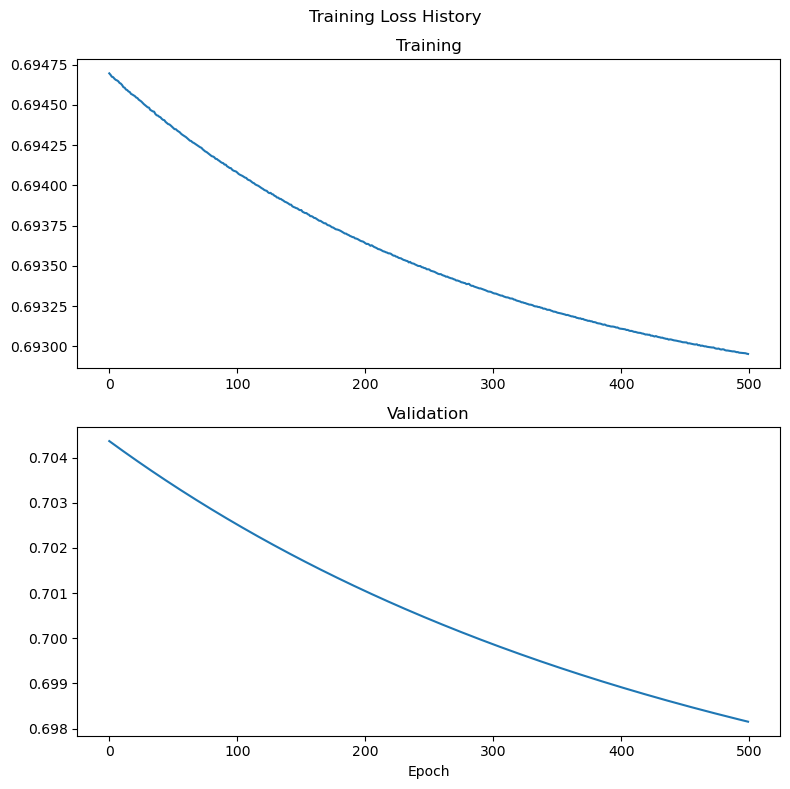

In [8]:
#below code adapted from wk 7 regression logreg.py  

fig, axs = plt.subplots(2, figsize=(8, 8))
fig.suptitle('Training Loss History')
axs[0].plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
axs[0].set_title('Training')
axs[1].plot(np.arange(len(per_epoch_loss_val)), per_epoch_loss_val)
axs[1].set_title('Validation')
plt.xlabel('Epoch')
fig.tight_layout()
plt.show()
# lol - very obvious bug in loss function, it's steadily increasing, not decreasing... I think it's somehow 1- loss ... 

### step 8: Report the accuracy of your classifier on your validation dataset.

In [9]:
print(per_epoch_loss_val[-1])

0.6981522467688795


## step 9: Explain your choice of loss function and hyperparameters.

see text under step 5, generate an instance of your NeuralNetwork class.